# 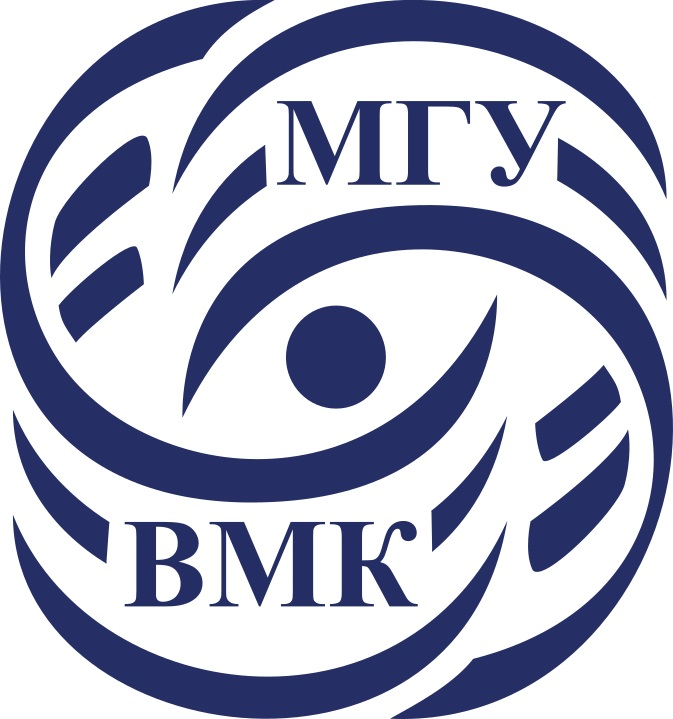

# Машинное обучение. ВМК МГУ

# Практическое задание 7: SVM
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)

-------
<font color="white" style="opacity:0.2025"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [23]:
! curl https://raw.githubusercontent.com/MSU-ML-COURSE/ML-COURSE-25-26/refs/heads/master/requirements/requirements.txt -o ./requirements_2025_26_for_colab_small.txt
! pip install -q -r ./requirements_2025_26_for_colab_small.txt

  % Total    % Received % Xferd  Average Speed  Time    Time    Time   Current
                                 Dload  Upload  Total   Spent   Left   Speed
100    360 100    360   0      0   1415      0                              0


Проверим версию библиотеки:

In [25]:
import catboost
assert(catboost.__version__ == '1.2.8')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2025"></font>

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

Приведем вспомогательный код

In [27]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [28]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [29]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [6]:
# import gdown
# gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

# SVM и разделяющая поверхность

На лекции вы изучили, что линейная, с виду, модель SVM, при помощи некоторых "фокусов", называемых ядрами, умеет строить нелинейные поверхности. В данном ноутбуке посмотрим, как это все работает на практике, и какие гиперпараметры настройки у этого метода есть.

<font color='MediumTurquoise'>**Историческая справка:**</font> Метод опорных векторов (SVM) стал популярным в 90-х годах, особенно с 1995 года, благодаря своей эффективности в задачах классификации и способности обрабатывать высокоразмерные данные. Он также привлек внимание благодаря использованию ядровых функций, что позволяло решать нелинейные задачи. Однако с появлением более сложных методов, таких как глубокое обучение, и увеличением объема данных, SVM стал менее популярным, поскольку более современные алгоритмы демонстрировали лучшие результаты на больших наборах данных и обеспечивали более простую настройку.

## <font color='DarkOrange'>**Задание 1 [1 балл]**</font>


В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.


    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью ```sklearn.svm.SVC(kernel='linear')```, а также нелинейную c rbf-ядром с помощью ```sklearn.svm.SVC(kernel='rbf')```. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [30]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

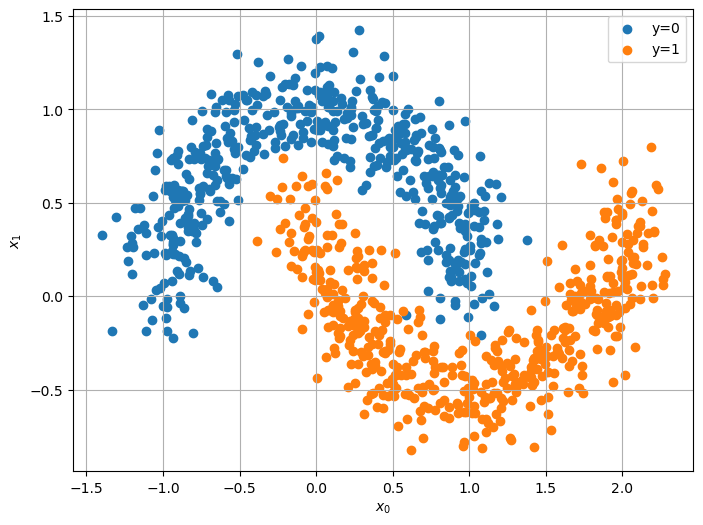

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

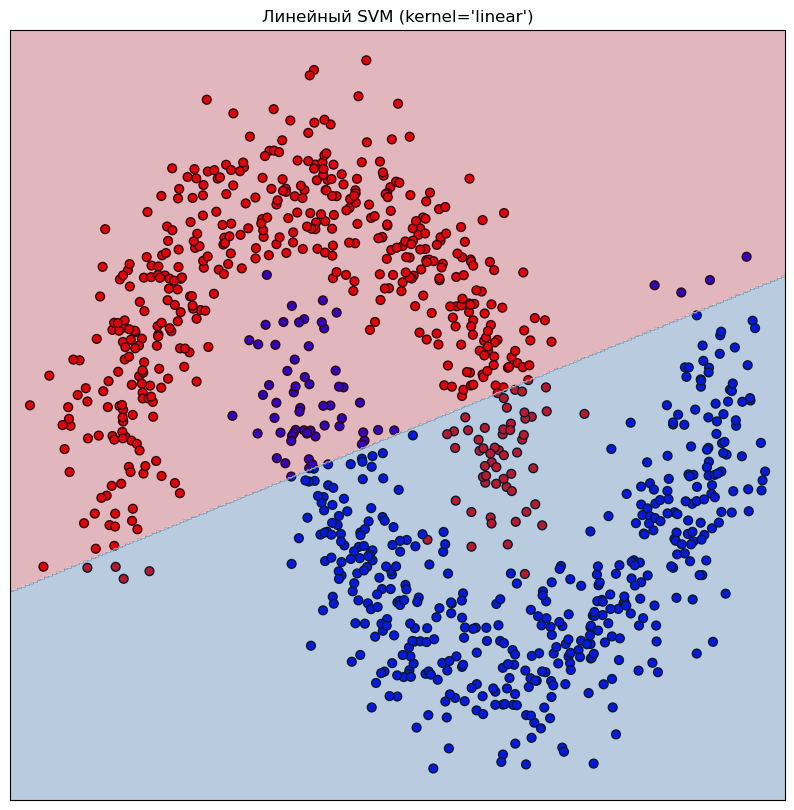

Train Accuracy (linear): 0.880


In [32]:
linear_svc.fit(X,y)
plot_separating_surface(X, y, linear_svc, title="Линейный SVM (kernel='linear')")
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')

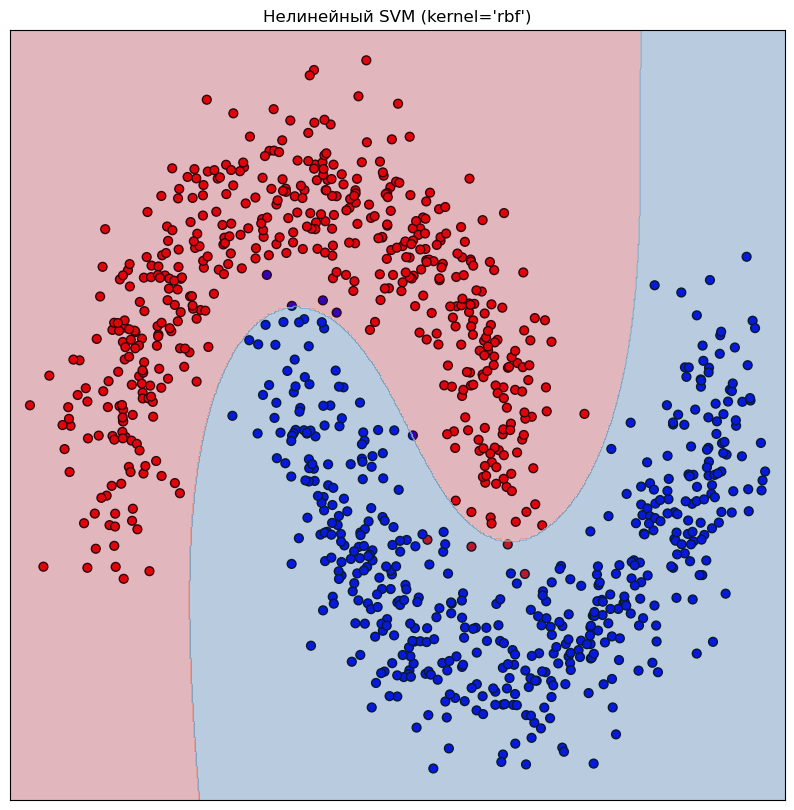

Train Accuracy (non linear): 0.991


In [33]:
nonlinear_svc.fit(X,y)
plot_separating_surface(X, y, nonlinear_svc, title="Нелинейный SVM (kernel='rbf')")
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Линейная SVM модель имеет низкую точность `= 0.887` на данных "луны", так как они линейно не разделимы.

Вторая модель SVM c нелинейным rbf ядром (Гауссовским) подходит ***явно лучше*** так как она строит уже точную изогнутую границу, которая практически идеально отделяет два множества друг от друга с точностью `= 0.986`

## 2. Опорные объекты

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

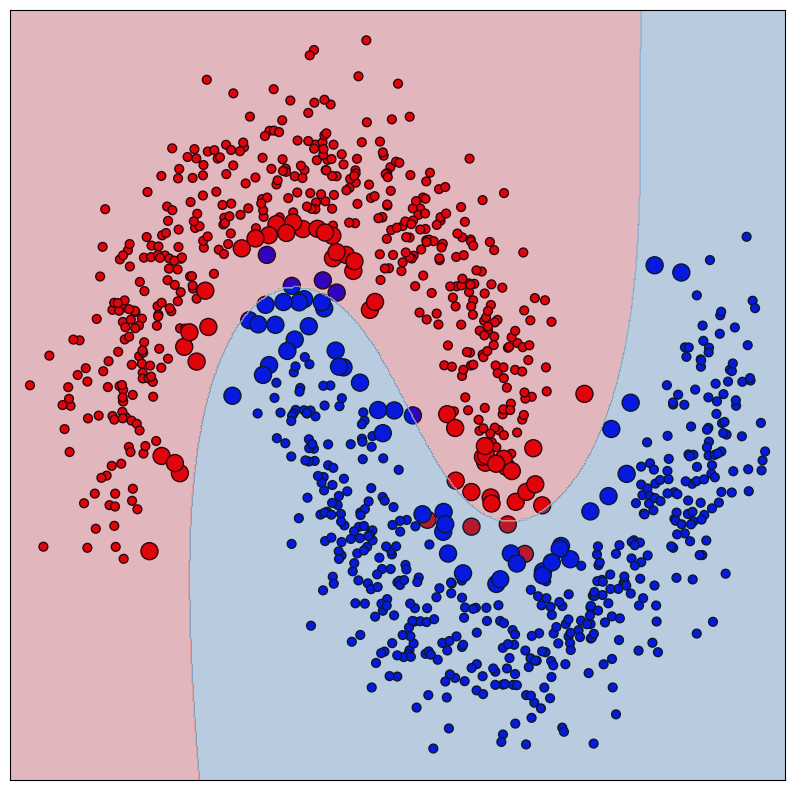

In [34]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

Обучим новые две модели ```SVC(kernel='rbf')```, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [35]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

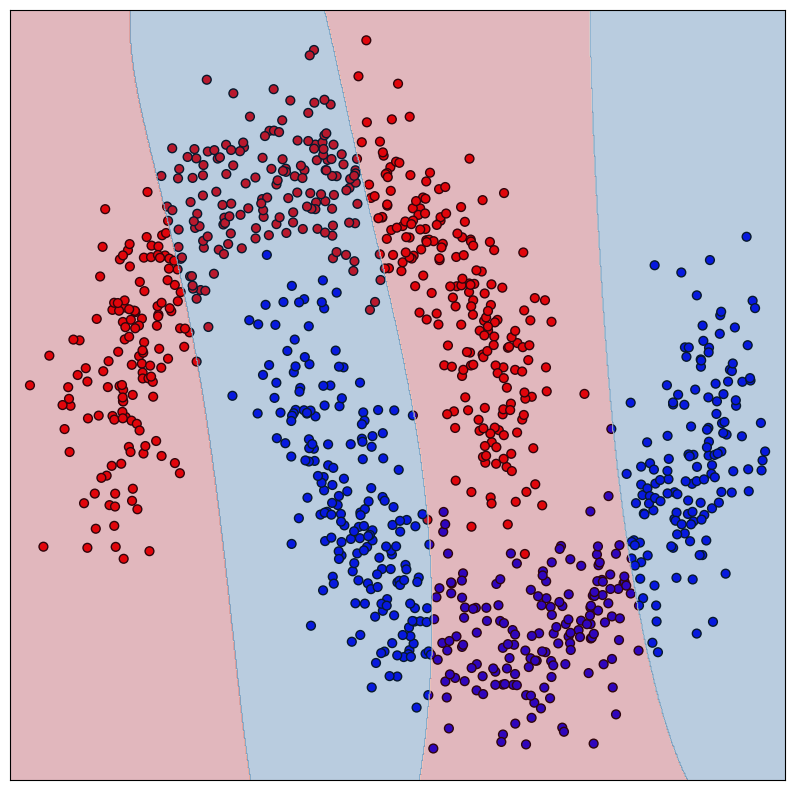

Train Accuracy (non linear): 0.679


In [36]:
plot_separating_surface(X, y, svc_on_linear_support)
print(f'Train Accuracy (non linear): {accuracy_score(y, svc_on_linear_support.predict(X)):.3f}')

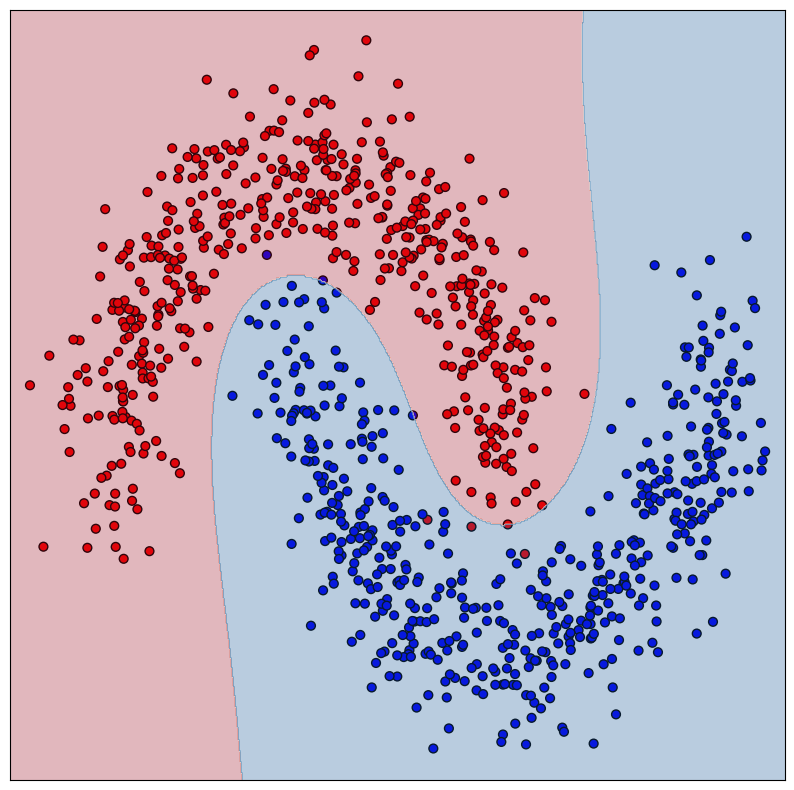

Train Accuracy (non linear): 0.995


In [37]:
plot_separating_surface(X, y, svc_on_rbf_support)
print(f'Train Accuracy (non linear): {accuracy_score(y, svc_on_rbf_support.predict(X)):.3f}')

### <font color='DarkOrange'>**Задание 2 [1 балл]**</font>

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из задания 1. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Больше похожа на нелинейную модель естественно **вторая** поверхность, так как она использовала для обучения опорные объекты, полученные в **такой же нелинейной модели** из первой части. Точность сохранилась `0.992`

**Первая** же модель использовала для обучения опорные объекты, полученные в **линейной модели** из первой части, которые распологались скоплениями на графике (из пункта 2), соответственно она построила границы вокруг этих овальнообразных скоплений. В результате чего только ухудшила точность до `0.671`

---

Теперь обучим модель ```SVC(kernel='rbf')```, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из задания 1(nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [38]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

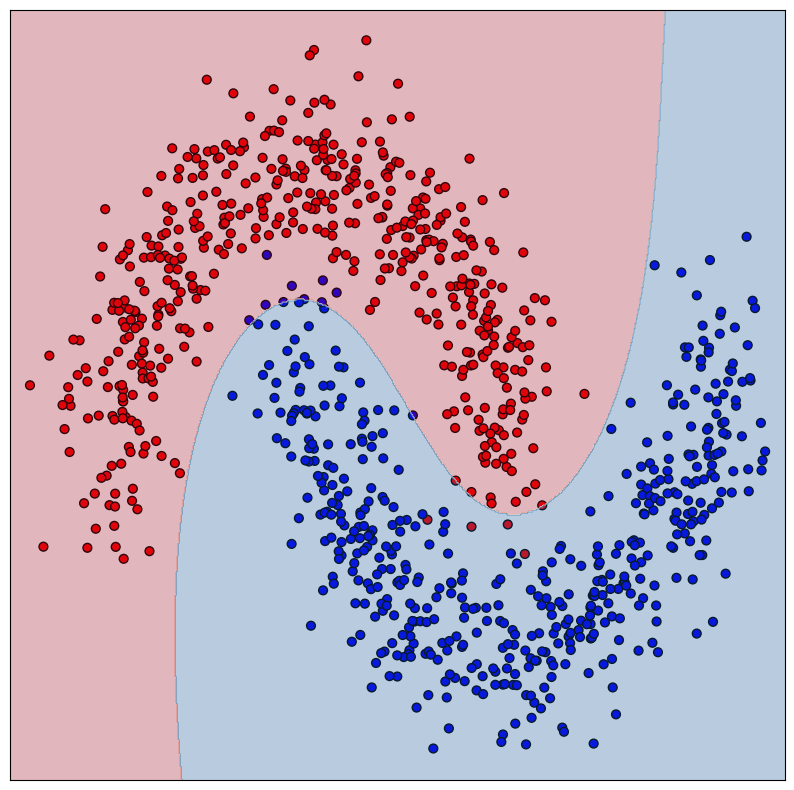

In [39]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

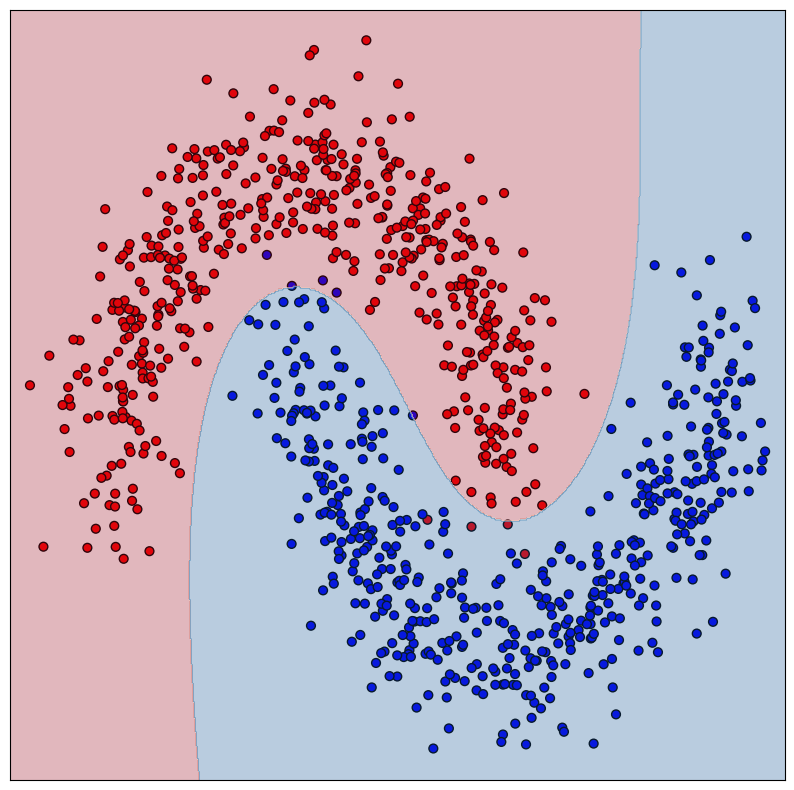

In [40]:
plot_separating_surface(X, y, nonlinear_svc)

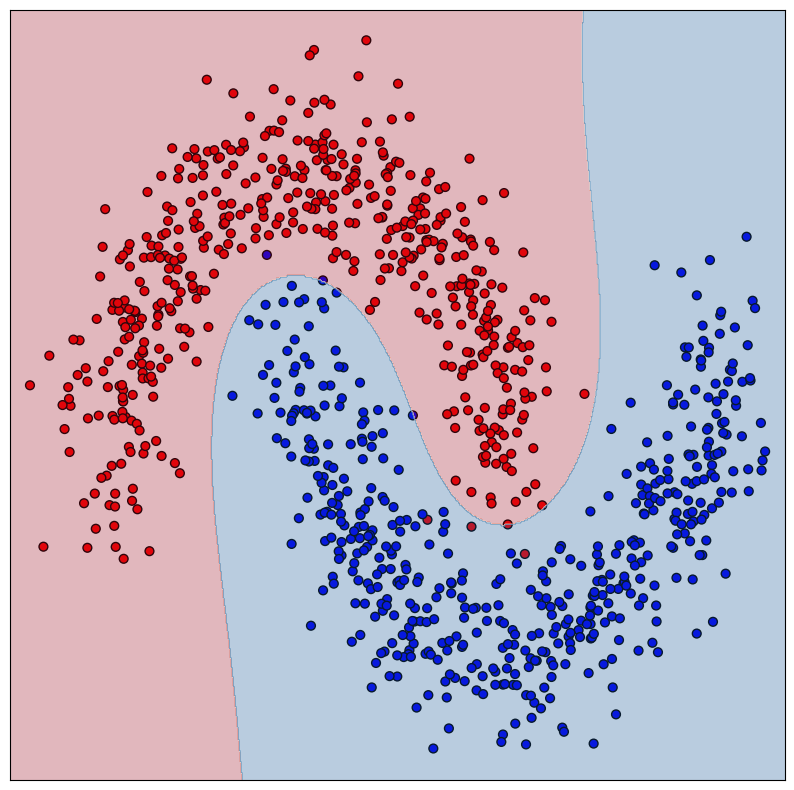

In [41]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 3 [1.5 баллa]**</font>

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первом задании? Что произошло с пограничными объектами? Объясните полученные результаты.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Полученные поверхности не сильно отличаются от той, что была получена в первом задании, за исключением лучшей классификации (огибания) некоторых единичных точек в модели `svc_on_rbf_support`, которые использовались как опорные объекты.

#### Пограничные объекты

а) Параметр регуляризации C

Даже если рядом нет точек другого класса, SVM все равно стремится:

1) Максимизировать зазор между классами

2) Минимизировать норму весов (регуляризация)

При обучении на малом наборе опорных векторов, модель может создать "искусственные" изгибы, чтобы удовлетворить обоим требованиям.

б) Свойство полноты RBF-ядра

RBF-ядро является универсальным ядром — оно может аппроксимировать любую непрерывную функцию. На краях выборки, где данных мало, модель "додумывает" поведение функции, часто создавая плавные переходы.

На краю области, где x далеко от всех опорных векторов:

1) Все члены $e^{-γ||x - x_i||²} \rightarrow 0$
2) Остается только f(x) ≈ b

Но если есть крайняя опорная точка x_edge, то:

1) Когда x приближается к x_edge, $e^{-γ||x - x_{edge}||²} → 1$

2) Это создает локальный "горб"

# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [42]:
X_train = np.load('./content/05-SVM/public/cX_train.npy')
y_train = np.load('./content/05-SVM/public/cy_train.npy')
X_test = np.load('./content/05-SVM/public/cX_test.npy')

In [43]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [44]:
X = X_train
y = y_train.ravel()

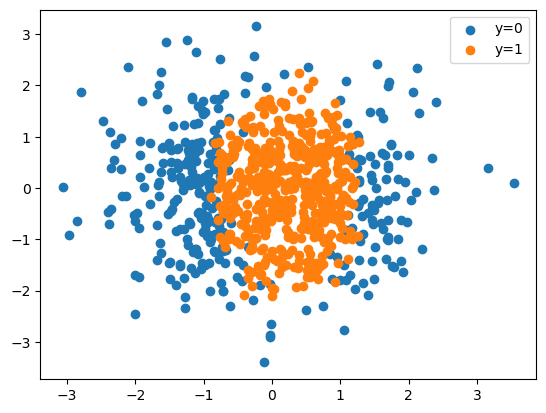

In [45]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

In [46]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


def find_best_svm_params(X_train, y_train):

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42))
    ])

    param_grid = [
        {
            'svm__kernel': ['linear'],
            'svm__C': [0.01, 0.1, 1, 3, 7, 10, 100, 1000]
        },
        {
            'svm__kernel': ['rbf'],
            'svm__C': [0.01, 0.1, 1, 3, 7, 10, 100, 1000],
            'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
        },
        {
            'svm__kernel': ['poly'],
            'svm__C': [0.01, 0.1, 1, 3, 7, 10, 100, 1000],
            'svm__degree': [2, 3, 4, 5],
            'svm__gamma': ['scale', 'auto']
        }
    ]


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("\n" + "="*60)
    print("ПОДБОР ГИПЕРПАРАМЕТРОВ С КРОСС-ВАЛИДАЦИЕЙ")
    print("="*60)

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)


    print("\nЛучшие параметры:", grid_search.best_params_)
    print("Лучшая точность на кросс-валидации: {:.4f}".format(grid_search.best_score_))


    print("\nТоп-5 комбинаций параметров:")
    results = grid_search.cv_results_
    top_indices = np.argsort(results['mean_test_score'])[-5:][::-1]

    return grid_search.best_estimator_, grid_search.best_params_


def train_svm_and_predict(train_features, train_target, test_features):

   # Подбор оптимальных параметров
    best_model, best_params = find_best_svm_params(train_features, train_target)

    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel=best_params['svm__kernel'],
            C=best_params.get('svm__C', 1),
            gamma=best_params.get('svm__gamma', 'scale'),
            degree=best_params.get('svm__degree', 3),
            random_state=42
        ))
    ])

    final_pipeline.fit(train_features, train_target)
    predictions = final_pipeline.predict(test_features)

    # Оценка на обучающей выборке
    train_accuracy = final_pipeline.score(train_features, train_target)
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")

    return predictions

if __name__ == "__main__":

    X_train = np.load('./content/05-SVM/public/cX_train.npy')
    y_train = np.load('./content/05-SVM/public/cy_train.npy')
    X_test = np.load('./content/05-SVM/public/cX_test.npy')


    train_svm_and_predict(X_train, y_train, X_test)


ПОДБОР ГИПЕРПАРАМЕТРОВ С КРОСС-ВАЛИДАЦИЕЙ
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Лучшие параметры: {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Лучшая точность на кросс-валидации: 0.9263

Топ-5 комбинаций параметров:
Точность на обучающей выборке: 0.9513


# Сравнение с логистической регрессией

#### <font color='DarkOrange'>**Задание 4 [1.5 баллa]**</font>

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from sklearn.svm import SVC
import pandas as pd

In [48]:
# Your code here
X_train = np.load('./content/05-SVM/public/cX_train.npy')
y_train = np.load('./content/05-SVM/public/cy_train.npy')
X_test = np.load('./content/05-SVM/public/cX_test.npy')


def analyze_logistic_regression_performance(X_train, y_train):

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, max_iter=1000))
    ])

    param_grids = [
        {
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logreg__penalty': ['l1', 'l2'],
            'logreg__solver': ['liblinear']
        },

        {
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logreg__penalty': ['l2'],
            'logreg__solver': ['lbfgs', 'newton-cg', 'sag']
        },

        {
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logreg__penalty': ['l1', 'l2', 'elasticnet', None],
            'logreg__solver': ['saga'],
            'logreg__l1_ratio': [0.1, 0.5, 0.9]
        }
    ]


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("\n" + "="*70)
    print("ПОДБОР ГИПЕРПАРАМЕТРОВ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
    print("="*70)

    best_score = -1
    best_params = None
    best_estimator = None
    all_results = []

    for i, param_grid in enumerate(param_grids):

        print(f"\nНабор параметров {i+1}/{len(param_grids)}:")
        print(f"  Решатели: {param_grid['logreg__solver']}")
        print(f"  Регуляризации: {param_grid['logreg__penalty']}")

        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)

        for params, mean_score in zip(grid_search.cv_results_['params'],
                                        grid_search.cv_results_['mean_test_score']):
            all_results.append((params, mean_score))


        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
            best_estimator = grid_search.best_estimator_

        print(f"  Лучшая точность в этом наборе: {grid_search.best_score_:.4f}")


    print(f"\nОбщие лучшие параметры: {best_params}")
    print(f"Общая лучшая точность на кросс-валидации: {best_score:.4f}")


    # Обучаем лучшую модель на всех данных
    best_estimator.fit(X_train, y_train)

    # Получаем коэффициенты
    logreg_model = best_estimator.named_steps['logreg']

    return best_estimator, best_params, best_score

def compare_svm_vs_logreg(X_train, y_train):

    print("\n" + "="*70)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ: SVM vs ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
    print("="*70)


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # SVM модель
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1000, gamma=0.01, random_state=42))
    ])

    # Логистическая регрессия
    logreg_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(
            C=0.1,
            penalty='l1',
            solver='liblinear',
            random_state=42,
            max_iter=1000
        ))
    ])

    svm_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=cv, scoring='accuracy')

    print(f"\nSVM (RBF kernel):")
    print(f"  Средняя точность: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")
    print(f"  Диапазон: [{svm_scores.min():.4f}, {svm_scores.max():.4f}]")

    print(f"\nЛогистическая регрессия (L1, C=0.1):")
    print(f"  Средняя точность: {logreg_scores.mean():.4f} ± {logreg_scores.std():.4f}")
    print(f"  Диапазон: [{logreg_scores.min():.4f}, {logreg_scores.max():.4f}]")


    return svm_pipeline, logreg_pipeline, svm_scores, logreg_scores


if __name__ == "__main__":

    best_logreg, best_params, best_score = analyze_logistic_regression_performance(X_train, y_train)


    svm_model, logreg_model, svm_scores, logreg_scores = compare_svm_vs_logreg(X_train, y_train)

    print("\n" + "="*70)
    print("ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ")
    print("="*70)

    # Обучаем SVM на всех данных
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1000, gamma=0.01, random_state=42))
    ])

    svm_pipeline.fit(X_train, y_train)

    # Обучаем логистическую регрессию на всех данных
    logreg_pipeline = best_logreg
    logreg_pipeline.fit(X_train, y_train)

    # Делаем предсказания
    svm_predictions = svm_pipeline.predict(X_test)
    logreg_predictions = logreg_pipeline.predict(X_test)


    agreement = np.mean(svm_predictions == logreg_predictions)
    print(f"\nСогласованность предсказаний SVM и LogReg: {agreement:.2%}")

    if agreement < 0.8:
        print("Модели дают существенно разные предсказания!")
    else:
        print("Модели дают схожие предсказания.")


ПОДБОР ГИПЕРПАРАМЕТРОВ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

Набор параметров 1/3:
  Решатели: ['liblinear']
  Регуляризации: ['l1', 'l2']
  Лучшая точность в этом наборе: 0.8125

Набор параметров 2/3:
  Решатели: ['lbfgs', 'newton-cg', 'sag']
  Регуляризации: ['l2']
  Лучшая точность в этом наборе: 0.7812

Набор параметров 3/3:
  Решатели: ['saga']
  Регуляризации: ['l1', 'l2', 'elasticnet', None]


/home/tapok/.conda/envs/conda_env_ml_course/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/tapok/.conda/envs/conda_env_ml_course/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/tapok/.conda/envs/conda_env_ml_course/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/tapok/.conda/envs/conda_env_ml_course/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/tapok/.conda/envs/conda_env_ml_course/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196:

  Лучшая точность в этом наборе: 0.8025

Общие лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Общая лучшая точность на кросс-валидации: 0.8125

СРАВНИТЕЛЬНЫЙ АНАЛИЗ: SVM vs ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

SVM (RBF kernel):
  Средняя точность: 0.9263 ± 0.0127
  Диапазон: [0.9062, 0.9437]

Логистическая регрессия (L1, C=0.1):
  Средняя точность: 0.8125 ± 0.0088
  Диапазон: [0.8000, 0.8250]

ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ

Согласованность предсказаний SVM и LogReg: 75.00%
Модели дают существенно разные предсказания!


Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

**Сильное влияние**: C - важный гиперпараметр. Правильная комбинация С и gamma в bfg ядре может значиткльно улучшить качкство модели.

- **Малые значения (C=0.001-0.1)**: Сильная регуляризация

- **Большие значения (C=100-1000)**: Слабая регуляризация
  - Риск переобучения
  - Модель слишком чувствительна к шуму
  - Точность на кросс-валидации: **снижается**

**Решатели играют также важную роль в Логистической регрессии**
- **lbfgs**:
  - Рекомендуемый по умолчанию
  - Быстрый, стабильный
  - Поддерживает только L2
  - **Наилучшая точность** в большинстве случаев

- **liblinear**:
  - Поддерживает L1 и L2
  - Хорош для небольших данных
  - Медленнее на больших выборках


**Ядро:**
- **Linear**:
  - Линейная разделяющая поверхность
  - Быстрое обучение
  - Подходит для линейно разделимых данных
  - **Низкая точность** на сложных данных

- **RBF (Радиальное)**:
  - Нелинейная разделяющая поверхность
  - Универсальное ядро
  - **Высокая точность** на сложных данных
  - Риск переобучения при неправильном подборе gamma

- **Polynomial**:
  - Полиномиальная разделяющая поверхность
  - Чувствителен к степени полинома
  - Может переобучаться

**Gamma:**
- **Малые значения**:
  - Большой радиус влияния
  - Более плавная граница
  - Похоже на линейную модель
  - **Стабильнее**, меньше переобучения

- **Большие значения**:
  - Маленький радиус влияния
  - Очень сложная граница
  - **Риск переобучения**
  - Чувствительность к шуму

- **'scale' (автоматический)**:
  - Рекомендуемое значение
  - Адаптируется к масштабу данных
  - **Наилучший выбор** в большинстве случаев, но не в нашем

#### **Что помогло:**

1. Выбор ядра **RBF**, которое превзошло линейное, так как данные были нелинейны
2. **Масштабирование признаков** было важно для обеих моделей
3. **Кросс-валидация** позволила надежно оценить обобщающую способность

### <font color='MediumSeaGreen'>**Задание 5 [1 балл][Bonus]**</font>

Найдите мем про SVM лучше чем этот:

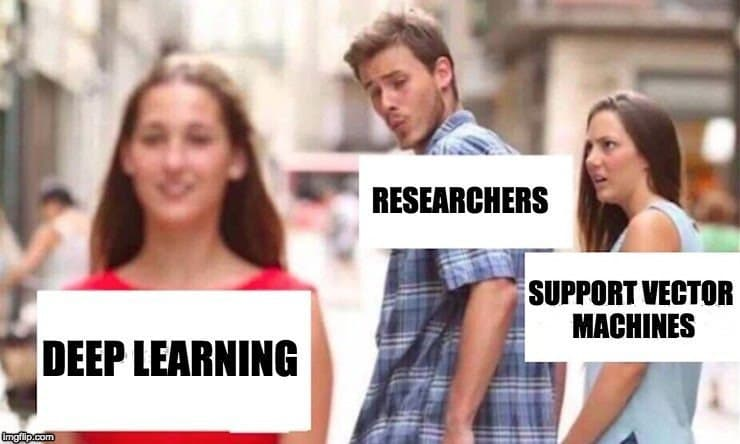

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

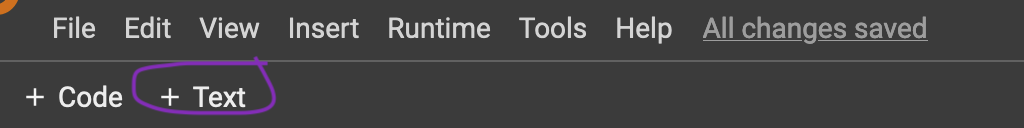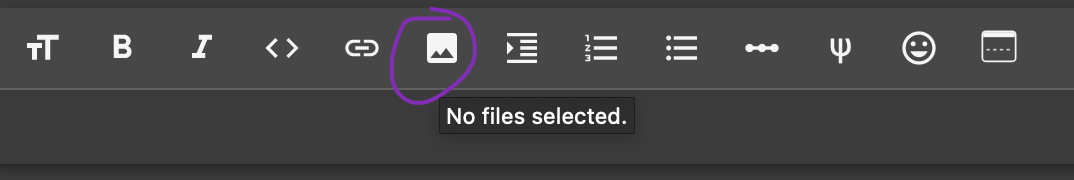

![meme](./pictures/giga_corgy.png)